In [1]:
#2021.07.06. TUE
#Hankyeong

#00. 패키지 호출 
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt 
import warnings 
import re
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Embedding, SimpleRNN
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from scipy.linalg import toeplitz

#00-1. 시각화 옵션 설정
%matplotlib inline

#00-2. warning message ignore
warnings.filterwarnings(action='ignore')

#00-3. 씨드넘버 설정
np.random.seed(2021)
tf.random.set_seed(2021)


In [2]:
#08. SMS 데이터셋 전처리하기. 
#(1) 데이터셋 불러오기. 
spam_raw = pd.read_csv('../../data/spam.csv', encoding='latin1')
spam_raw

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN
...,...,...,...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...,NaN,NaN,NaN
5568,ham,Will Ì_ b going to esplanade fr home?,NaN,NaN,NaN
5569,ham,"Pity, * was in mood for that. So...any other s...",NaN,NaN,NaN
5570,ham,The guy did some bitching but I acted like i'd...,NaN,NaN,NaN


In [3]:
#(2) 필요 변수만 추출하기. 
spam = pd.DataFrame({
    'feature' : spam_raw['v2'],
    'target'  : spam_raw['v1']
})
spam

,feature,target
0,"Go until jurong point, crazy.. Available only ...",ham
1,Ok lar... Joking wif u oni...,ham
2,Free entry in 2 a wkly comp to win FA Cup fina...,spam
3,U dun say so early hor... U c already then say...,ham
4,"Nah I don't think he goes to usf, he lives aro...",ham
...,...,...
5567,This is the 2nd time we have tried 2 contact u...,spam
5568,Will Ì_ b going to esplanade fr home?,ham
5569,"Pity, * was in mood for that. So...any other s...",ham
5570,The guy did some bitching but I acted like i'd...,ham


In [4]:
#(3) target 변수 레이블 인코딩하기. 
spam['target'] = spam['target'].replace(['ham','spam'], [0,1])
spam

,feature,target
0,"Go until jurong point, crazy.. Available only ...",0
1,Ok lar... Joking wif u oni...,0
2,Free entry in 2 a wkly comp to win FA Cup fina...,1
3,U dun say so early hor... U c already then say...,0
4,"Nah I don't think he goes to usf, he lives aro...",0
...,...,...
5567,This is the 2nd time we have tried 2 contact u...,1
5568,Will Ì_ b going to esplanade fr home?,0
5569,"Pity, * was in mood for that. So...any other s...",0
5570,The guy did some bitching but I acted like i'd...,0


In [5]:
#(4) 결측치 확인하기. 
spam.isna().sum()

feature    0
target     0
dtype: int64

In [6]:
#(5) target 변수의 unique값 확인하기. 
spam['target'].unique()

array([0, 1], dtype=int64)

In [7]:
#(6) target 변수의 분포 확인하기. 
spam['target'].value_counts()

0    4825
1     747
Name: target, dtype: int64

In [8]:
#(7) feature 변수의 중복 데이터 확인하기. 
spam['feature'].nunique()

5169

In [9]:
#(8) feature 변수의 중복 데이터 제거하기. 
spam.drop_duplicates(subset='feature', keep='first', inplace=True)
spam

,feature,target
0,"Go until jurong point, crazy.. Available only ...",0
1,Ok lar... Joking wif u oni...,0
2,Free entry in 2 a wkly comp to win FA Cup fina...,1
3,U dun say so early hor... U c already then say...,0
4,"Nah I don't think he goes to usf, he lives aro...",0
...,...,...
5567,This is the 2nd time we have tried 2 contact u...,1
5568,Will Ì_ b going to esplanade fr home?,0
5569,"Pity, * was in mood for that. So...any other s...",0
5570,The guy did some bitching but I acted like i'd...,0


In [10]:
#(9) feature, target 데이터 분할하기. 
X_data = spam['feature'].values
y_data = spam['target'].values

#(10) feature, target 데이터 차원 확인하기. 
X_data.shape, y_data.shape

((5169,), (5169,))

In [11]:
#09. feature 데이터 텍스트 처리하기. 
#(1) 숫자와 영어를 제외한 모든 문자 삭제하고 소문자처리하기.  
X_data_pre = []
for x in X_data : 
    x_pre = re.sub('[^0-9A-Za-z ]','',x).lower()
    X_data_pre.append(x_pre)

#(2) sample의 첫 10개 확인하기. 
X_data_pre[:10]

['go until jurong point crazy available only in bugis n great world la e buffet cine there got amore wat',
 'ok lar joking wif u oni',
 'free entry in 2 a wkly comp to win fa cup final tkts 21st may 2005 text fa to 87121 to receive entry questionstd txt ratetcs apply 08452810075over18s',
 'u dun say so early hor u c already then say',
 'nah i dont think he goes to usf he lives around here though',
 'freemsg hey there darling its been 3 weeks now and no word back id like some fun you up for it still tb ok xxx std chgs to send 150 to rcv',
 'even my brother is not like to speak with me they treat me like aids patent',
 'as per your request melle melle oru minnaminunginte nurungu vettam has been set as your callertune for all callers press 9 to copy your friends callertune',
 'winner as a valued network customer you have been selected to receivea 900 prize reward to claim call 09061701461 claim code kl341 valid 12 hours only',
 'had your mobile 11 months or more u r entitled to update to 

In [12]:
#(3) keras의 Tonkenizer 객체 지정하기. 
tokenizer = Tokenizer()

#(4) 토큰화하기. 
tokenizer.fit_on_texts(X_data_pre)

#(5) 단어집합 설정하기. 
voca_size = len(tokenizer.word_index) +1 
voca_size

9479

In [13]:
#(6) keras에 맞게 index 처리하기. 
sequences = tokenizer.texts_to_sequences(X_data_pre)

#(7) 첫 sample 구조 확인하기. 
print(sequences[0])

[43, 410, 3837, 729, 663, 699, 65, 8, 1138, 93, 118, 459, 1139, 146, 2565, 1140, 68, 56, 3838, 133]


In [14]:
#(8) sample의 최대 길이 확인하기. 
max_len = max(len(l) for l in sequences)
max_len

171

In [15]:
#(9) 패딩 처리하기. 
X_data_pad = pad_sequences(sequences, maxlen=max_len)

#(10) 패딩 처리 후 차원 확인하기. 
X_data_pad.shape

(5169, 171)

In [16]:
#(11) train, test 데이터셋으로 분할하기. 
X_train, X_test, y_train, y_test = train_test_split(
    X_data_pad, y_data, stratify=y_data, test_size=0.2, random_state=2021
)

#(12) train, test 데이터셋의 차원 확인하기. 
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((4135, 171), (4135,), (1034, 171), (1034,))

In [17]:
#03. RNN 모델로 이진 분류하기. 
#(1) 모델 정의하기. 
model = Sequential([
    Embedding(voca_size, 32, input_length = max_len),
    SimpleRNN(128),
    Dense(1, activation='sigmoid')
])

#(2) 모델의 요약 정보 확인하기. 
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 171, 32)           303328    
_________________________________________________________________
simple_rnn (SimpleRNN)       (None, 128)               20608     
_________________________________________________________________
dense (Dense)                (None, 1)                 129       
Total params: 324,065
Trainable params: 324,065
Non-trainable params: 0
_________________________________________________________________


In [18]:
#(3) 모델의 컴파일 설정하기.
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics='accuracy'
)

#(4) checkpointer 객체 할당하기. 
MODEL_PATH = '../../model/spam_best_RNN_model.h5'
checkpointer = ModelCheckpoint(
    filepath=MODEL_PATH,
    monitor='val_loss',
    save_best_only=True,
    verbose=0
)

#(5) earlystopping 객체 할당하기. 
earlystopping = EarlyStopping(
    monitor='val_loss',
    patience=15
)

#(6) 모델 학습하기. 
model_fit = model.fit(
    X_train,
    y_train,
    validation_split=0.2,
    callbacks=[checkpointer, earlystopping],
    epochs=2500,
    verbose=0
)

#(7) best 모델 할당하기. 
best_model = load_model(MODEL_PATH)

#(8) best 모델로 예측하기. 
best_model.evaluate(X_test,y_test)

33/33 [==============================] - 1s 27ms/step - loss: 0.1307 - accuracy: 0.9594


[0.1307288259267807, 0.9593810439109802]

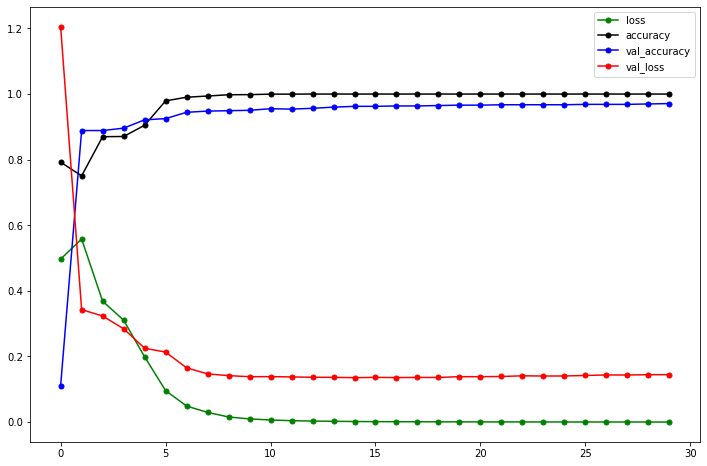

In [19]:
#(9) 학습 과정 시각화하기. 
plt.figure(figsize=(12,8))
y_val_loss = model_fit.history['val_loss']
y_loss = model_fit.history['loss']
y_val_accuracy = model_fit.history['val_accuracy']
y_accuracy = model_fit.history['accuracy']
x_len = np.arange(len(y_val_loss))

plt.plot(x_len, y_loss, 'go-', markersize=5, label='loss')
plt.plot(x_len, y_accuracy, 'ko-', markersize=5, label='accuracy')

plt.plot(x_len, y_val_accuracy, 'bo-', markersize=5, label='val_accuracy')
plt.plot(x_len, y_val_loss, 'ro-', markersize=5, label='val_loss')

plt.legend()
plt.show()